In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import datetime
import requests
import pandas as pd

In [4]:
import sys
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
from gensim import corpora
import pickle
import gensim
import re
from nltk.corpus import wordnet as wn
import spacy
from nltk.stem.wordnet import WordNetLemmatizer
from spacy.lang.en import English
import random
from datetime import datetime
import nltk
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
import ssl
import pickle
from operator import add


C:\Users\Marketlytics\anaconda3\envs\finsent\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [5]:

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            continue
        elif token.orth_.startswith('@'):
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    tokens = [token for token in tokens if token != "SCREEN_NAME"]

    return tokens



def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text
def getMaxTopic(ls):
    return max(ls,key=itemgetter(1))[0]

In [6]:
stopwords = set(STOPWORDS)
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
from spacy.lang.en import English
spacy.load('en')
parser = English()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marketlytics\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marketlytics\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:


analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

def text_blob_analyzer(text):

    sent = TextBlob(text)

    polarity      = sent.sentiment.polarity

    return polarity

def getSentiment(df,text_field):
    df['vader_dict'] = df[text_field].apply(sentiment_analyzer_scores)
    df['textblob_compound'] = df[text_field].apply(text_blob_analyzer)
    df['vader_compound'] = [i['compound'] for i in df['vader_dict']]
    df['textblob_compound'] = df[text_field].apply(text_blob_analyzer)
    df['vader_compound'] = [i['compound'] for i in df['vader_dict']]
    df['vader_compound'] = [i['compound'] for i in df['vader_dict']]
    return df

def getSentAndTopics(user,inp_df,text_field):
    global trump_id2word,trump_lda_model,biden_id2word,biden_lda_model,trump_topic_json,biden_topic_json

    threshold = 0.35
    
    other_texts = [prepare_text_for_lda(x) for x in inp_df[text_field]]
    if user == "trump":
        other_corpus = [trump_id2word.doc2bow(text) for text in other_texts]
        inp_df['topic_list'] = trump_lda_model[other_corpus]
    else:
        other_corpus = [biden_id2word.doc2bow(text) for text in other_texts]
        inp_df['topic_list'] = biden_lda_model[other_corpus]

    inp_df['topic'] = inp_df['topic_list'].apply(getMaxTopic)

    if user == "trump":
        topic_json = trump_topic_json.copy()
    else:
        topic_json = biden_topic_json.copy()

    inp_df = getSentiment(inp_df,text_field)
    overall_sentiment = inp_df['vader_compound'].describe()
    overall_sentiment['neg']=len(inp_df[inp_df["vader_compound"]<=-1*(threshold)])
    overall_sentiment['pos']=len(inp_df[inp_df["vader_compound"]>=(threshold)])
    overall_sentiment['neu']=100-overall_sentiment['pos']-overall_sentiment['neg']
    overall_sentiment['user']=user
    
    topic_group = inp_df.groupby('topic')['vader_compound'] 
    topic_wise_sentiment = topic_group.describe()
    topic_group = pd.DataFrame(topic_group)
    topic_wise_sentiment['pos']=[sum(x>=threshold) for x in topic_group[1]]
    topic_wise_sentiment['neg']=[sum(x<=-1*threshold) for x in topic_group[1]]
    topic_wise_sentiment['neu']=topic_wise_sentiment['count']-topic_wise_sentiment['neg']-topic_wise_sentiment['pos']
    final_table = pd.merge(pd.DataFrame(topic_json),topic_wise_sentiment,left_on="topic",right_index=True)
    final_table.sort_values(by="count",ascending=False,inplace=True)
    final_table["user"]=user

    return final_table,overall_sentiment

def getModel(startDate):
    global trump_id2word,trump_lda_model,biden_id2word,biden_lda_model,trump_topic_json,biden_topic_json
    
    f_name = "biden"+str(startDate.month)
    biden_lda_model = LdaMulticore.load('models/'+f_name+'.gensim')
    biden_id2word = Dictionary.load('models/'+f_name+'.gensim.id2word')

    with open('models/'+f_name+'.json') as f_open: 
        biden_topic_json = json.loads(json.load(f_open))
        
    f_name = "trump"+str(startDate.month)

    trump_lda_model = LdaMulticore.load('models/'+f_name+'.gensim')
    trump_id2word = Dictionary.load('models/'+f_name+'.gensim.id2word')

    with open('models/'+f_name+'.json') as f_open: 
        trump_topic_json = json.loads(json.load(f_open))
        
    return True,f_name

def backupJson(backup_name,js_store):
    with open('json_backups/'+backup_name+'.json','w+') as backup_file:
        json.dump(js_store,backup_file)

In [678]:
topic_sentiment_month = pd.DataFrame()
total_sentiment_month = pd.DataFrame()
total_link_df = pd.DataFrame()
total_subreddit_df = pd.DataFrame()
total_created_df = pd.DataFrame()

In [12]:
trump_id2word=None
trump_lda_model=None
trump_topic_json=None

biden_id2word=None
biden_lda_model=None
biden_topic_json=None

In [680]:
unixtime = 1577836800 - 86400

In [681]:
1604016000

1604016000

In [682]:
while unixtime<1604016000:
    unixtime = unixtime+86400
    startDate = datetime.utcfromtimestamp(unixtime).date()
    print(startDate)
    if startDate.day==1:
        print("Month Complete - Fetching new model")
        model_status = getModel(startDate)
        print(model_status)
        total_sentiment_month.to_pickle("total_sentiment_month.pkl")
        topic_sentiment_month.to_pickle("topic_sentiment_month.pkl")
        total_link_df.to_pickle("total_link_df.pkl")
        total_subreddit_df.to_pickle("total_subreddit_df.pkl")
        total_created_df.to_pickle("total_created_df.pkl")

    print("Fetching data for "+str(startDate))
    url = 'https://data-management-ac8c8.firebaseio.com/'+str(unixtime)+'.json'
    try:
        response = requests.get(url)
        js_content = response.json()
        backupJson(str(unixtime),js_content)
    except:
        print("ERROR")
   

    for user in ['trump','biden']:
        print(user,end = " ")
        
        comment_df = pd.DataFrame(js_content[user]['comment']['data'])
        topic_sentiment,total_sentiment = getSentAndTopics(user,comment_df,'body')
        topic_sentiment['date']=startDate
        topic_sentiment_month = topic_sentiment_month.append(topic_sentiment)
        
        total_sentiment = pd.DataFrame().append(total_sentiment,ignore_index=True)
        total_sentiment['date']=startDate
        total_sentiment_month = total_sentiment_month.append(total_sentiment,ignore_index=True)        
        
        print("links",end=" ")
        
        links = js_content[user]['link_agg']['aggs']['link_id']

        link_dict = {
            'doc_count':[],
            'id':[],
            'author':[],
            'num_comments':[],
            'num_crossposts':[],
            'title':[],
            'created_utc':[],
            'score':[],
            'subreddit':[],
            'total_awards_received':[],
            'subreddit_subscribers':[],
            'url':[]

        }
        for l in links:
            for k in link_dict:
                if k=="doc_count":
                    link_dict[k].append(l[k])
                else:
                    link_dict[k].append(l['data'][k])     

        link_df = pd.DataFrame(link_dict)
        link_df["user"] = user
        link_df["date"]=startDate
        link_df = getSentiment(link_df,'title').head(5)

        total_link_df = total_link_df.append(link_df)

        print("Created and Subreddits",end=" ")
        
        created = js_content[user]['created_agg']['aggs']['created_utc'][0:24]
        subreddits = js_content[user]['subreddit_agg']['aggs']['subreddit']
        subreddit_dict = {
            'doc_count':[],
            'key':[]
        }
        created_dict = {

            "doc_count":[]

        }

        for sb in subreddits:
            for k in subreddit_dict:
                subreddit_dict[k].append(sb[k])  

        for c in created:
            created_dict['doc_count'].append(c['doc_count'])

        subreddit_df= pd.DataFrame(subreddit_dict).head(5)
        subreddit_df["date"]=startDate
        subreddit_df["user"]=user

        total_subreddit_df = total_subreddit_df.append(subreddit_df)

        created_df = pd.DataFrame(created_dict)
        created_df["date"]=startDate
        created_df["user"]=user

        total_created_df = total_created_df.append(created_df)


2020-01-01
Month Complete - Fetching new model
(True, 'trump1')
Fetching data for 2020-01-01
trump links Created and Subreddits biden links Created and Subreddits 2020-01-02
Fetching data for 2020-01-02
trump links Created and Subreddits biden links Created and Subreddits 2020-01-03
Fetching data for 2020-01-03
trump links Created and Subreddits biden links Created and Subreddits 2020-01-04
Fetching data for 2020-01-04
trump links Created and Subreddits biden links Created and Subreddits 2020-01-05
Fetching data for 2020-01-05
trump links Created and Subreddits biden links Created and Subreddits 2020-01-06
Fetching data for 2020-01-06
trump links Created and Subreddits biden links Created and Subreddits 2020-01-07
Fetching data for 2020-01-07
trump links Created and Subreddits biden links Created and Subreddits 2020-01-08
Fetching data for 2020-01-08
trump links Created and Subreddits biden links Created and Subreddits 2020-01-09
Fetching data for 2020-01-09
trump links Created and Sub

trump links Created and Subreddits biden links Created and Subreddits 2020-03-15
Fetching data for 2020-03-15
trump links Created and Subreddits biden links Created and Subreddits 2020-03-16
Fetching data for 2020-03-16
trump links Created and Subreddits biden links Created and Subreddits 2020-03-17
Fetching data for 2020-03-17
trump links Created and Subreddits biden links Created and Subreddits 2020-03-18
Fetching data for 2020-03-18
trump links Created and Subreddits biden links Created and Subreddits 2020-03-19
Fetching data for 2020-03-19
trump links Created and Subreddits biden links Created and Subreddits 2020-03-20
Fetching data for 2020-03-20
trump links Created and Subreddits biden links Created and Subreddits 2020-03-21
Fetching data for 2020-03-21
trump links Created and Subreddits biden links Created and Subreddits 2020-03-22
Fetching data for 2020-03-22
trump links Created and Subreddits biden links Created and Subreddits 2020-03-23
Fetching data for 2020-03-23
trump link

trump links Created and Subreddits biden links Created and Subreddits 2020-05-28
Fetching data for 2020-05-28
trump links Created and Subreddits biden links Created and Subreddits 2020-05-29
Fetching data for 2020-05-29
trump links Created and Subreddits biden links Created and Subreddits 2020-05-30
Fetching data for 2020-05-30
trump links Created and Subreddits biden links Created and Subreddits 2020-05-31
Fetching data for 2020-05-31
trump links Created and Subreddits biden links Created and Subreddits 2020-06-01
Month Complete - Fetching new model
(True, 'trump6')
Fetching data for 2020-06-01
trump links Created and Subreddits biden links Created and Subreddits 2020-06-02
Fetching data for 2020-06-02
trump links Created and Subreddits biden links Created and Subreddits 2020-06-03
Fetching data for 2020-06-03
trump links Created and Subreddits biden links Created and Subreddits 2020-06-04
Fetching data for 2020-06-04
trump links Created and Subreddits biden links Created and Subreddi

trump links Created and Subreddits biden links Created and Subreddits 2020-10-22
Fetching data for 2020-10-22
trump links Created and Subreddits biden links Created and Subreddits 2020-10-23
Fetching data for 2020-10-23
trump links Created and Subreddits biden links Created and Subreddits 2020-10-24
Fetching data for 2020-10-24
trump links Created and Subreddits biden links Created and Subreddits 2020-10-25
Fetching data for 2020-10-25
trump links Created and Subreddits biden links Created and Subreddits 2020-10-26
Fetching data for 2020-10-26
trump links Created and Subreddits biden links Created and Subreddits 2020-10-27
Fetching data for 2020-10-27
trump links Created and Subreddits biden links Created and Subreddits 2020-10-28
Fetching data for 2020-10-28
trump links Created and Subreddits biden links Created and Subreddits 2020-10-29
Fetching data for 2020-10-29
trump links Created and Subreddits biden links Created and Subreddits 2020-10-30
Fetching data for 2020-10-30
trump link

In [683]:
from datetime import timedelta

# Reading Data from Pickle Objects

In [684]:
topic = pd.read_pickle('topic_sentiment_month.pkl')
total = pd.read_pickle('total_sentiment_month.pkl')
link = pd.read_pickle('total_link_df.pkl')
created = pd.read_pickle('total_created_df.pkl')
subreddit = pd.read_pickle('total_subreddit_df.pkl')


# Uploading to Firebase

In [685]:
processedDict={"topic":topic.to_json(orient="records"),"total":total.to_json(orient="records"),"link":link.to_json(orient="records"),"created":created.to_json(orient="records"),"subreddit":subreddit.to_json(orient="records")}

In [686]:
result_message = requests.put('https://data-management-ac8c8.firebaseio.com/aggregated.json',json.dumps(processedDict))

# Getting Processed Reddit from Firebase

In [523]:
import json
import pandas as pd

test_message = requests.get('https://data-management-ac8c8.firebaseio.com/aggregated.json')

test_dict = test_message.json()
topic = pd.DataFrame(json.loads(test_dict["topic"]))
total = pd.DataFrame(json.loads(test_dict["total"]))
link = pd.DataFrame(json.loads(test_dict["link"]))
created = pd.DataFrame(json.loads(test_dict["created"]))
subreddit = pd.DataFrame(json.loads(test_dict["subreddit"]))

topic["date_format"] = [datetime.utcfromtimestamp(u/1000).date() for u in topic["date"]]
total["date_format"] = [datetime.utcfromtimestamp(u/1000).date() for u in total["date"]]
link["date_format"] = [datetime.utcfromtimestamp(u/1000).date() for u in link["date"]]
created["date_format"] = [datetime.utcfromtimestamp(u/1000).date() for u in created["date"]]
subreddit["date_format"] = [datetime.utcfromtimestamp(u/1000).date() for u in subreddit["date"]]

# Basic Visualization

In [480]:
import seaborn as sns

In [493]:
xt=total[total[17]=="trump"]
yt=total[total[17]=="biden"]

<AxesSubplot:xlabel='date', ylabel='11'>

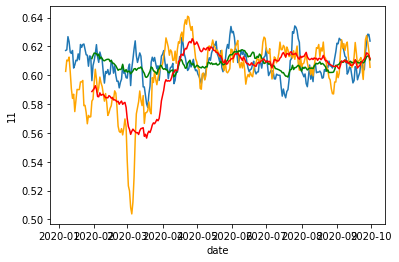

In [506]:
sns.lineplot(data=xt, x=xt["date"], y=xt[11].rolling(7).mean())
sns.lineplot(data=yt, x=yt["date"], y=yt[11].rolling(7).mean(),color="orange")
sns.lineplot(data=xt, x=xt["date"], y=xt[11].rolling(30).mean(),color="green")
sns.lineplot(data=yt, x=yt["date"], y=yt[11].rolling(30).mean(),color="red")


# Twitter Data Processing

In [8]:
r_trump_tweets = requests.get('https://data-management-ac8c8.firebaseio.com/tweets/trump.json')
r_biden_tweets = requests.get('https://data-management-ac8c8.firebaseio.com/tweets/biden.json')
trump_tweets = r_trump_tweets.json()
biden_tweets = r_biden_tweets.json()


In [10]:
r_trump_tweets = requests.get('https://data-management-ac8c8.firebaseio.com/tweets/trump.json')
r_biden_tweets = requests.get('https://data-management-ac8c8.firebaseio.com/tweets/biden.json')
trump_tweets = r_trump_tweets.json()
biden_tweets = r_biden_tweets.json()
biden_df = pd.DataFrame(biden_tweets)
trump_df = pd.DataFrame(trump_tweets)

# Uploading Twitter Data to Firebase

In [18]:
processed_biden_df = getSentiment(biden_df,'text')
processed_trump_df = getSentiment(trump_df,'text')
processedDict={"biden":processed_biden_df.to_json(orient="records"),"trump":processed_trump_df.to_json(orient="records")}

In [19]:
result_message = requests.put('https://data-management-ac8c8.firebaseio.com/twitter_aggregated.json',json.dumps(processedDict))

# Getting Twitter Data From Firebase

In [21]:
import json
import pandas as pd

test_message = requests.get('https://data-management-ac8c8.firebaseio.com/twitter_aggregated.json')

test_dict = test_message.json()
biden_df = pd.DataFrame(json.loads(test_dict["biden"]))
trump_df = pd.DataFrame(json.loads(test_dict["trump"]))
biden_df["_date"] = [datetime.utcfromtimestamp(u/1000).date() for u in biden_df["_date"]]
trump_df["_date"] = [datetime.utcfromtimestamp(u/1000).date() for u in trump_df["_date"]]

In [27]:
a

NameError: name 'a' is not defined